# Lab:  Nonlinear Least Squares for Modeling Materials

In this lab, we will explore gradient descent on nonlinear least squares.  Suppose we wish to fit a model of the form,

     yhat = f(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  In nonlinear least squares, we find `w` by minimizing a least-squares function 

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  In general, this optimization has no closed-form expression.  So gradient descent is widely used.  

In this lab, we will implement gradient descent on nonlinear least squares in physical modeling of materials.  Specifically, e we will estimate parameters for expansion of copper as a function of temperature.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for trying nonlinear regression problem.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0', 'dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

Text(0, 0.5, 'y')

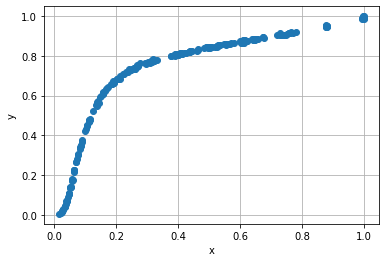

In [3]:
# TODO
# x0 = ...
# y0 = ...
# x0 = x0/np.max(x0)
# y0 = y0/np.max(y0)
# plt.plot(...)
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0) 
plt.plot(x,y,'o')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

Text(0, 0.5, 'y')

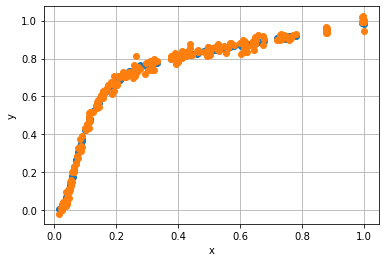

In [4]:
# TODO
# yn = y + ...
n = len(y0)
yn = y + np.random.normal(0,0.02,n)

plt.plot(x,y,'o')
plt.plot(x,yn,'o')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    # b = ...
    a = w[:d+1]
    b = w[d+1:]
    
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    # yhat = ...
    arev = a[::-1]
    brev = b[::-1]
    znum = np.polyval(arev,x)
    zden = 1+x*np.polyval(brev,x)
    yhat = znum/zden
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [7]:
d = 3

# TODO.  Create the transformed feature matrix
# Z = ...
powd = np.arange(1,d+1)
Znum = xtr[:,None]**powd[None,:]
Zden = -ytr[:,None]*Znum
Z = np.hstack((Znum, Zden))

# TODO.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)
regr = LinearRegression()
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...
w0 = regr.coef_
a0 = regr.intercept_
winit = np.hstack((a0,w0))

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

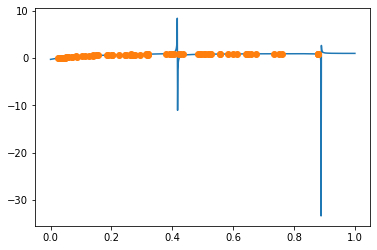

In [8]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp = np.linspace(0,1,1000)
yhat  = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts, yts, 'o')

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

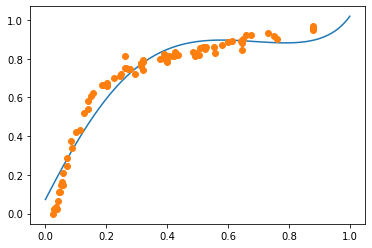

In [9]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)
regr = Ridge(alpha=1e-2)
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
w0 = regr.coef_
a0 = regr.intercept_
winit = np.hstack((a0,w0))

# TODO
# Plot the results as above.
xp = np.linspace(0,1,1000)
yhat  = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts, yts, 'o')


## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
        
    
    # TODO.  Parse w
    # a = ...
    # b = ...
    d = (len(w)-1)//2
    a = w[:d+1]
    b = w[d+1:]
    
    # TODO.  Znum[i,j] = x[i]**j
    pow1 = np.arange(0,d+1)
    Znum = x[:,None]**pow1[None,:]

    # TODO.  Zden[i,j] = x[i]**(j+1)
    pow2 = np.arange(1,d+1)
    Zden = x[:,None]**pow2[None,:]
    
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    rnum = Znum.dot(a)
    rden = Zden.dot(b)
    yhat = rnum/(1+rden)
    
    # TODO.  Compute loss
    # f = ...
    e = yhat-y
    f = 0.5*np.sum(e**2)
    
    # TODO.  Compute gradients
    # fgrad = ...
    eden = e/(1+rden)
    dJ_da = eden.dot(Znum)
    enum = -e*yhat/(1+rden)
    dJ_db = enum.dot(Zden)    
    fgrad = np.hstack((dJ_da, dJ_db))
    
    
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO
w0 = winit
p = len(winit)
w1 = w0 + np.random.normal(0,1,p)*1e-6
f0, fgrad0 = feval(w0,xtr,ytr)
f1, fgrad1 = feval(w1,xtr,ytr)

print('Actual diff   =%12.4e' % (f1-f0))
print('Expected diff =%12.4e' % (fgrad0.dot(w1-w0)) )

Actual diff   = -1.2219e-07
Expected diff = -1.2222e-07


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

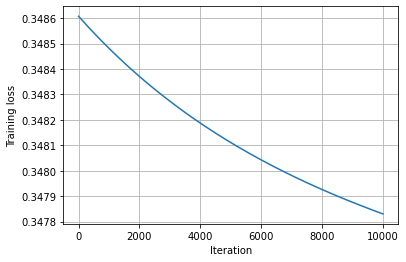

In [12]:
nit = 10000
step = 1e-6
wt = winit
fgd = np.zeros(nit)
for it in range(nit):
    ft, fgradt = feval(wt,xtr,ytr)
    fgd[it] = ft                
    wt  = wt - step*fgradt
        
plt.plot(fgd)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid()

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

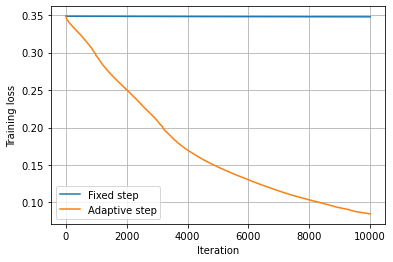

In [13]:
nit = 10000
step = 1e-6  # Initial step
w0 = winit
fadapt = np.zeros(nit)
f0, fgrad0 = feval(w0,xtr,ytr)
for it in range(nit):
    
    # Compute test point
    w1 = w0 - step*fgrad0
    f1, fgrad1 = feval(w1,xtr,ytr)            

    # Test Armijo rule
    alpha = 0.5
    if (f1-f0 < alpha*fgrad0.dot(w1-w0)) and (f1 < f0):
        step = step*2
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
    else:
        step = 0.5*step
    fadapt[it] = f0                
    
    
plt.plot(fgd)
plt.plot(fadapt)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend(['Fixed step', 'Adaptive step'])
plt.grid()

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

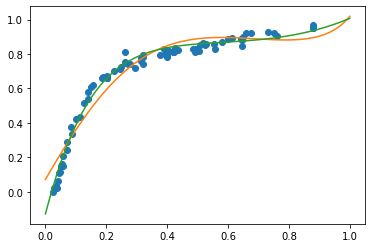

In [14]:
xp = np.linspace(0,1,500)
yinit = predict(winit,xp)
yhat = predict(w0,xp)
plt.plot(xts,yts,'o')
plt.plot(xp,yinit,'-')
plt.plot(xp,yhat,'-')


## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

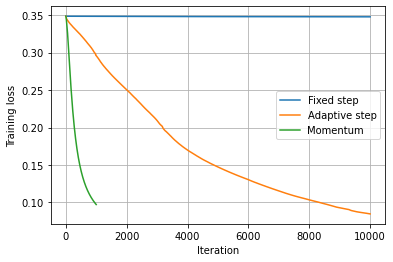

In [15]:
nit = 1000
step = 1e-3
beta = 0.99
wt = winit
p = len(winit)
z = np.zeros(p)
fmom = np.zeros(nit)
for it in range(nit):
    ft, fgradt = feval(wt,xtr,ytr)
    z = beta*z + fgradt
    wt  = wt - step*z
    fmom[it] = ft                
        
plt.plot(fgd)
plt.plot(fadapt)
plt.plot(fmom)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend(['Fixed step', 'Adaptive step', 'Momentum'])
plt.grid()

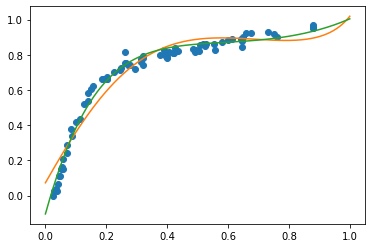

In [16]:
xp = np.linspace(0,1,500)
yinit = predict(winit,xp)
yhat = predict(wt,xp)
plt.plot(xts,yts,'o')
plt.plot(xp,yinit,'-')
plt.plot(xp,yhat,'-')